In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


nbPicture = 0

dataDirectory = '/kaggle/input/radiolarian-images/Radiolarian images' #replace by the directory of your images

import os
for dirname, _, filenames in os.walk(dataDirectory):
    for filename in filenames:
        nbPicture += 1
print (nbPicture)

1087


In [2]:
%matplotlib inline


!pip install nengo  #comment this
!pip install nengo_dl   #comment this



import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gc
import nengo_dl

     |████████████████████████████████| 523 kB 2.0 MB/s 
     |████████████████████████████████| 283 kB 2.1 MB/s 
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for nengo-dl: filename=nengo_dl-3.4.1-py3-none-any.whl size=204595 sha256=29eaef93bf364b9785a01eb56967e1a0c03dd4e4f22ff8e145ae67a51fd8b5c0
  Stored in directory: /root/.cache/pip/wheels/9e/55/af/7a54eb26bb6cc8d6d64d0d87231f95c98ec71a03444097ba41
Successfully built nengo-dl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nengo-dl 3.4.1 requires tensorflow>=2.2.0, which is not installed.


First we'll load the data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

batchSize = 64

target_size = 160

# Load the train data and test data

train_data_dir = dataDirectory


train_datagen = ImageDataGenerator()
itr = train_datagen.flow_from_directory(
train_data_dir,
target_size=(target_size, target_size),
batch_size=nbPicture,
class_mode='sparse')

label_map = (itr.class_indices)
print(label_map)

X, y = itr.next()

print("X shape = ", X.shape)
print("y shape = ", y.shape)

train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.15)
    
print("x_train shape = ", train_images.shape)
print("x_test shape = ", test_images.shape)
print("y_train shape = ", train_labels.shape)
print("y_test shape = ", test_labels.shape)

train_images = np.float32(train_images) / 255
test_images = np.float32(test_images) / 255


# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

Found 1087 images belonging to 8 classes.
{'Podocyrtis ampla': 0, 'Podocyrtis chalara': 1, 'Podocyrtis diamesa': 2, 'Podocyrtis goetheana': 3, 'Podocyrtis mitra': 4, 'Podocyrtis papalis': 5, 'Podocyrtis phyxis': 6, 'Podocyrtis sinuosa': 7}
X shape =  (1087, 160, 160, 3)
y shape =  (1087,)
x_train shape =  (923, 160, 160, 3)
x_test shape =  (164, 160, 160, 3)
y_train shape =  (923,)
y_test shape =  (164,)


In [4]:
with nengo.Network(seed=0) as net:
    gain = 100
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    #net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    #net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([gain])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = 0.1
    neuron_type = nengo.SpikingRectifiedLinear(amplitude=0.001)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(160 * 160 * 3))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=7))(
        inp, shape_in=(160, 160, 3)
    )
    x = nengo_dl.Layer(neuron_type)(x)
    
    
    #x = nengo_dl.Layer(tf.keras.layers.Dropout(0.15))(x)

    
    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=7))(
        x, shape_in=(154, 154, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)
    
    #x = nengo_dl.Layer(tf.keras.layers.Dropout(0.15))(x)
    
    
    x = nengo_dl.Layer(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="same"))(
        x, shape_in=(74, 74, 64))
    

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=7))(
        x, shape_in=(74, 74, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)
    
    #x = nengo_dl.Layer(tf.keras.layers.Dropout(0.15))(x)
    
    
    # add the fourth convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=256, strides=2, kernel_size=5))(
        x, shape_in=(34, 34, 128)
    )
    x = nengo_dl.Layer(neuron_type)(x)


    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=8))(x)
    
   
    
    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [5]:
minibatch_size = 20
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:12                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:03                                               


In [6]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In [7]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:1922: UserWarning: Number of elements in input data (164) is not evenly divisible by Simulator.minibatch_size (20); input data will be truncated.
  f"Number of elements in input data ({data_batch}) is not "


Accuracy before training: 0.26249998807907104


In [8]:
# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)
sim.fit(train_images, {out_p: train_labels}, epochs=10)

# save the parameters to file
sim.save_params("./small_spiking_params")
    
del train_images
del train_labels
gc.collect()

/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:1922: UserWarning: Number of elements in input data (923) is not evenly divisible by Simulator.minibatch_size (20); input data will be truncated.
  f"Number of elements in input data ({data_batch}) is not "


Epoch 1/10
46/46 [==============================] - 20s 62ms/step - loss: 2.0362 - out_p_loss: 2.0362
Epoch 2/10
46/46 [==============================] - 3s 62ms/step - loss: 1.6539 - out_p_loss: 1.6539
Epoch 3/10
46/46 [==============================] - 3s 62ms/step - loss: 1.1309 - out_p_loss: 1.1309
Epoch 4/10
46/46 [==============================] - 3s 62ms/step - loss: 0.9320 - out_p_loss: 0.9320
Epoch 5/10
46/46 [==============================] - 3s 62ms/step - loss: 0.8559 - out_p_loss: 0.8559
Epoch 6/10
46/46 [==============================] - 3s 62ms/step - loss: 0.6730 - out_p_loss: 0.6730
Epoch 7/10
46/46 [==============================] - 3s 63ms/step - loss: 0.5375 - out_p_loss: 0.5375
Epoch 8/10
46/46 [==============================] - 3s 62ms/step - loss: 0.4768 - out_p_loss: 0.4768
Epoch 9/10
46/46 [==============================] - 3s 61ms/step - loss: 0.3288 - out_p_loss: 0.3288
Epoch 10/10
46/46 [==============================] - 3s 63ms/step - loss: 0.2861 - out_p_l

6375

In [9]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy after training: 0.8187500238418579


1670

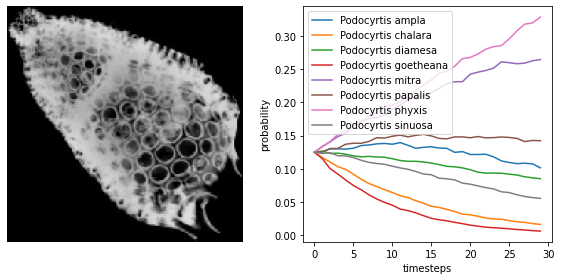

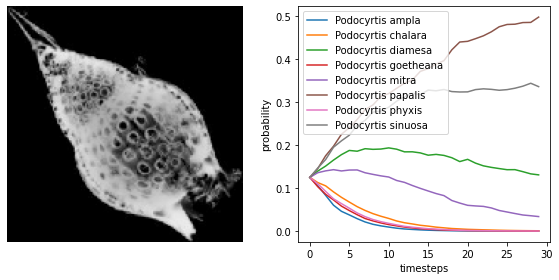

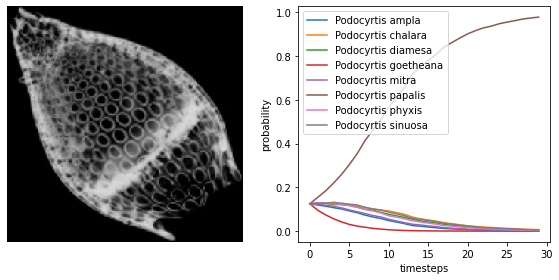

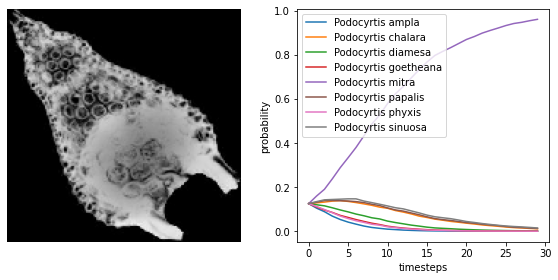

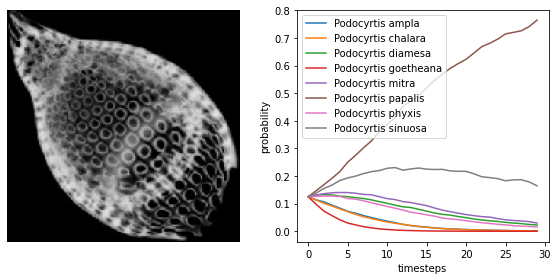

In [10]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((target_size, target_size, 3)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([list(label_map.items())[i][0] for i in range(8)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()
    
del data
del test_images
del test_labels
gc.collect()

In [11]:
sim.close()